In [1]:
import numpy as np
import scipy.stats
import torch
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import Dataset, DataLoader
np.random.seed(0)
torch.manual_seed(0)

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
def sample_data_1():
  count = 100000
  rand = np.random.RandomState(0)
  return [[1.0, 2.0]] + rand.randn(count, 2) * [[5.0, 1.0]]
def sample_data_2():
  count = 100000
  rand = np.random.RandomState(0)
  return [[1.0, 2.0]] + (rand.randn(count, 2) * [[5.0, 1.0]]).dot([[np.sqrt(2) / 2, np.sqrt(2) / 2], [-np.sqrt(2) / 2, np.sqrt(2) / 2]])

In [0]:
data_1 = sample_data_1()
data_2 = sample_data_2()

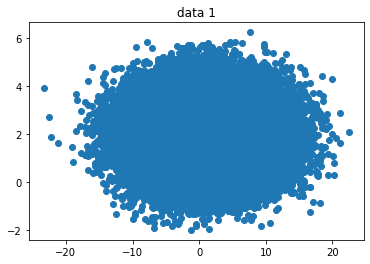

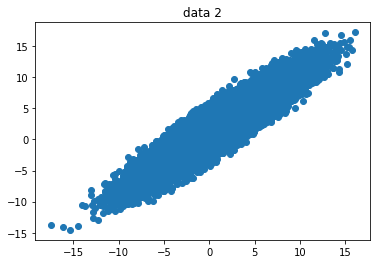

In [5]:
plt.title("data 1")
plt.scatter(data_1[:,0],data_1[:,1])
plt.show()
plt.title("data 2")
plt.scatter(data_2[:,0],data_2[:,1])
plt.show()

In [0]:
class VAE(nn.Module):
  def __init__(self,is_diagonal=True):
    super(VAE,self).__init__()
    self.fc_enc = nn.Linear(2,100)
    self.m_enc = nn.Linear(100,2)
    self.cov_enc = nn.Linear(100,2)
    self.fc_dec = nn.Linear(2,100)
    self.m_dec = nn.Linear(100,2)
    self.cov_dec = nn.Linear(100,2)
    self.cov_dec_scalar = nn.Linear(100,1)
    self.is_diagonal = is_diagonal

  def encoder(self,x):
    h = F.relu(self.fc_enc(x))
    mean = self.m_enc(h)
    logcov = self.cov_enc(h) #having the variance in log provides numerical stability 
    return mean,logcov

  def decoder(self,z):
    h = F.relu(self.fc_dec(z)) 
    mean = self.m_dec(h) 
    if self.is_diagonal:
      logcov = self.cov_dec(h) 
    else:
      logcov = self.cov_dec_scalar(h).repeat(1,2)
    return mean,logcov
  
  def forward(self,x,z):
    m_enc, logcov_enc = self.encoder(x)
    z_x =  m_enc + torch.exp(logcov_enc*0.5)*z
    m_dec,logcov_dec = self.decoder(z_x)
    return (m_enc, logcov_enc), (m_dec, logcov_dec)

In [0]:
def vec_prob(m,logcov,x):
    log_x_prob = torch.zeros(len(x))
    for i in range(len(log_x_prob)):
      m_i,cov_i = m[i], logcov[i].exp().unsqueeze(1)*torch.eye(2)
      log_x_prob[i] = torch.distributions.MultivariateNormal(m_i, cov_i).log_prob(x[i][None,None,...])
      
    return log_x_prob

In [0]:
def criterion(enc_stats,dec_stats,x):
  # reconstruction loss 
  log_x_prob=vec_prob(*dec_stats,x)
  reconst = torch.sum(log_x_prob *-1)/log_x_prob.shape[0]
  # KL - regularization term
  m_enc,logcov_enc = enc_stats
  reg = -0.5 * torch.sum(1+ logcov_enc -m_enc.pow(2)- logcov_enc.exp())/m_enc.shape[0]
  return reg,reconst

## Dataset 1

#### diagonal covariance model

In [0]:
model = VAE(is_diagonal=True)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
epochs_num= 10
batch_size = 1000
indices = np.arange(len(data_1))

In [10]:
## Dataset 1
train_loss,KL_loss,decoder_loss = [],[],[]
for epoch in range(epochs_num):
  np.random.shuffle(indices)
  loss_epoch,KL_epoch,Dec_epoch=0,0,0
  for i,index in enumerate(range(0,len(indices),batch_size)): 
    optimizer.zero_grad()
    z = torch.randn((batch_size,2))
    x = torch.from_numpy(data_1[indices[index:index+batch_size]]).float()
    output = model(x,z)
    KL,Dec = criterion(*output,x)
    loss = KL+Dec
    loss.backward()
    optimizer.step()
    loss_epoch +=loss.item()
    KL_epoch +=KL.item()
    Dec_epoch +=Dec.item()
  train_loss.append(loss_epoch/i)
  KL_loss.append(KL_epoch/i)
  decoder_loss.append(Dec_epoch/i)
  print("epoch #{} loss {}".format(epoch,np.log2(loss_epoch/i)))
  # model_save_name = 'vae.tar' 
  # path = F"/content/gdrive/My Drive/{model_save_name}"
  # state_dict = {"model": model.state_dict(), "optimizer": optimizer.state_dict()}
  # torch.save(state_dict, path)

epoch #0 loss 2.794766269377786
epoch #1 loss 2.3153913720637487
epoch #2 loss 2.231025393192069
epoch #3 loss 2.198758864293472
epoch #4 loss 2.187088074400137
epoch #5 loss 2.179496391094897
epoch #6 loss 2.1756648178771516
epoch #7 loss 2.1722464866254043
epoch #8 loss 2.1702761214195445
epoch #9 loss 2.1688179612971736


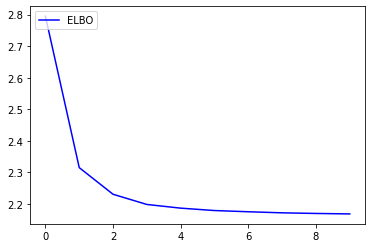

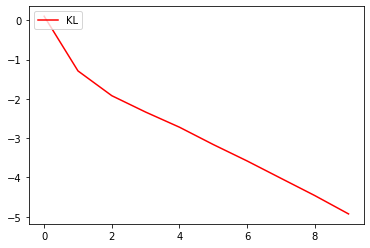

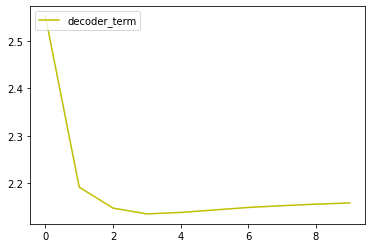

In [11]:
plt.plot(np.arange(epochs_num),np.log2(train_loss), '-b', label = 'ELBO')
plt.legend(loc='upper left')
plt.show()
plt.plot(np.arange(epochs_num),np.log2(KL_loss), '-r', label = 'KL')
plt.legend(loc='upper left')
plt.show()
plt.plot(np.arange(epochs_num),np.log2(decoder_loss), '-y', label = 'decoder_term')
plt.legend(loc='upper left') 
plt.show()

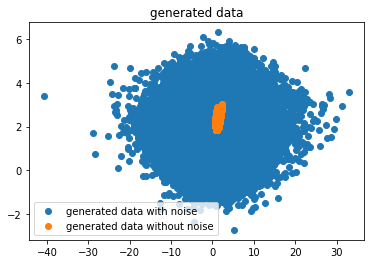

generated data mean tensor([1.0074, 2.0094], grad_fn=<MeanBackward1>) std tensor([5.0871, 1.0060], grad_fn=<StdBackward1>)


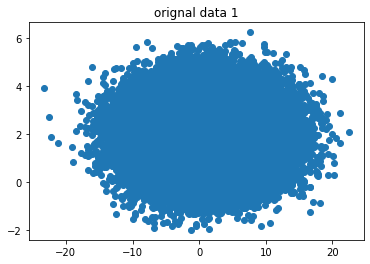

In [13]:
samples_num = 100000
z = torch.randn((samples_num,2))
z_=  torch.randn((samples_num,2))
m,cov = model.decoder(z)
samples_noise = m +  torch.exp(cov*0.5)*z_
samples = m
plt.title("generated data")
plt.scatter(samples_noise[:,0].detach(),samples_noise[:,1].detach(),label="generated data with noise")
plt.scatter(samples[:,0].detach(),samples[:,1].detach(),label="generated data without noise")
plt.legend()
plt.show()
print("generated data mean {} std {}".format(torch.mean(samples_noise,dim=0),torch.std(samples_noise,dim=0)))
plt.title("orignal data 1")
plt.scatter(data_1[:,0],data_1[:,1])
plt.show()

#### scalar variance model

In [0]:
model_scalar = VAE(is_diagonal=False)
optimizer = torch.optim.Adam(model_scalar.parameters(), lr=1e-3)
epochs_num= 10
batch_size = 1000
indices = np.arange(len(data_1))

In [10]:
## Dataset 1
train_loss,KL_loss,decoder_loss = [],[],[]
for epoch in range(epochs_num):
  np.random.shuffle(indices)
  loss_epoch,KL_epoch,Dec_epoch=0,0,0
  for i,index in enumerate(range(0,len(indices),batch_size)): 
    optimizer.zero_grad()
    z = torch.randn((batch_size,2))
    x = torch.from_numpy(data_1[indices[index:index+batch_size]]).float()
    output = model_scalar(x,z)
    KL,Dec = criterion(*output,x)
    loss = KL+Dec
    loss.backward()
    optimizer.step()
    loss_epoch +=loss.item()
    KL_epoch +=KL.item()
    Dec_epoch +=Dec.item()
  train_loss.append(loss_epoch/i)
  KL_loss.append(KL_epoch/i)
  decoder_loss.append(Dec_epoch/i)
  print("epoch #{} loss {}".format(epoch,np.log2(loss_epoch/i)))
  # model_save_name = 'vae_scalar.tar' 
  # path = F"/content/gdrive/My Drive/{model_save_name}"
  # state_dict = {"model": model_scalar.state_dict(), "optimizer": optimizer.state_dict()}
  # torch.save(state_dict, path)

epoch #0 loss 2.958861741892924
epoch #1 loss 2.5432998857076745
epoch #2 loss 2.4606123191581863
epoch #3 loss 2.4132808287185057
epoch #4 loss 2.3630733626110256
epoch #5 loss 2.3098841837613526
epoch #6 loss 2.252714880405465
epoch #7 loss 2.208212876150685
epoch #8 loss 2.185213809091737
epoch #9 loss 2.174629191190974


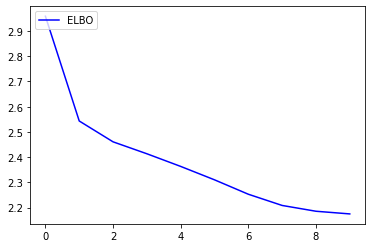

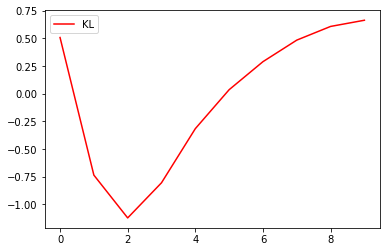

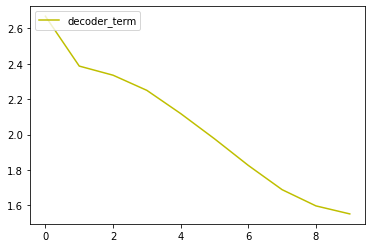

In [11]:
plt.plot(np.arange(epochs_num),np.log2(train_loss), '-b', label = 'ELBO')
plt.legend(loc='upper left')
plt.show()
plt.plot(np.arange(epochs_num),np.log2(KL_loss), '-r', label = 'KL')
plt.legend(loc='upper left')
plt.show()
plt.plot(np.arange(epochs_num),np.log2(decoder_loss), '-y', label = 'decoder_term')
plt.legend(loc='upper left') 

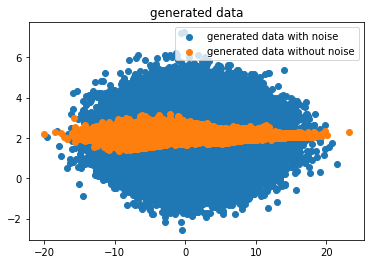

generated data mean tensor([0.9380, 2.0172], grad_fn=<MeanBackward1>) std tensor([4.9461, 1.0415], grad_fn=<StdBackward1>)


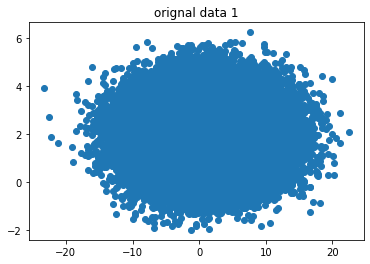

In [12]:
samples_num = 100000
z = torch.randn((samples_num,2))
z_=  torch.randn((samples_num,2))
# m,cov = model_scalar.encoder(torch.from_numpy(data_1).float())
m,cov = model_scalar.decoder(z)
samples_noise = m +  torch.exp(cov*0.5)*z_
samples = m
plt.title("generated data")
plt.scatter(samples_noise[:,0].detach(),samples_noise[:,1].detach(),label="generated data with noise")
plt.scatter(samples[:,0].detach(),samples[:,1].detach(),label="generated data without noise")
plt.legend()
plt.show()
print("generated data mean {} std {}".format(torch.mean(samples_noise,dim=0),torch.std(samples_noise,dim=0)))
plt.title("orignal data 1")
plt.scatter(data_1[:,0],data_1[:,1])
plt.show()

## Dataset 2

#### diagonal covariance model

In [0]:
model_2 = VAE()
optimizer = torch.optim.Adam(model_2.parameters(), lr=1e-3)
epochs_num= 10
batch_size = 1000
indices = np.arange(len(data_2))

In [13]:
## Dataset 2
train_loss_2,KL_loss_2,decoder_loss_2 = [],[],[]
for epoch in range(epochs_num):
  np.random.shuffle(indices)
  loss_epoch,KL_epoch,Dec_epoch=0,0,0
  for i,index in enumerate(range(0,len(indices),batch_size)): 
    optimizer.zero_grad()
    z = torch.randn((batch_size,2))
    x = torch.from_numpy(data_2[indices[index:index+batch_size]]).float()
    output = model_2(x,z)
    KL,Dec = criterion(*output,x)
    loss = KL+Dec
    loss.backward()
    optimizer.step()
    loss_epoch +=loss.item()
    KL_epoch +=KL.item()
    Dec_epoch +=Dec.item()
  train_loss_2.append(loss_epoch/i)
  KL_loss_2.append(KL_epoch/i)
  decoder_loss_2.append(Dec_epoch/i)
  print("epoch #{} loss {}".format(epoch,np.log2(loss_epoch/i)))
  # model_save_name = 'vae_2.tar' 
  # path = F"/content/gdrive/My Drive/{model_save_name}"
  # state_dict = {"model": model_2.state_dict(), "optimizer": optimizer.state_dict()}
  # torch.save(state_dict, path)

epoch #0 loss 2.996666671399907
epoch #1 loss 2.485870947057753
epoch #2 loss 2.382076574535034
epoch #3 loss 2.304188839038859
epoch #4 loss 2.2516454742194467
epoch #5 loss 2.2067170040058364
epoch #6 loss 2.183469843315258
epoch #7 loss 2.1727873917250657
epoch #8 loss 2.1704729009011716
epoch #9 loss 2.1691687729493268


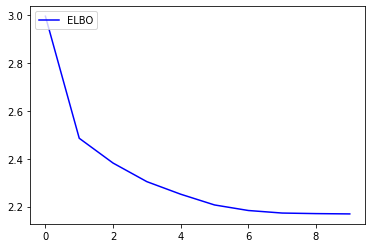

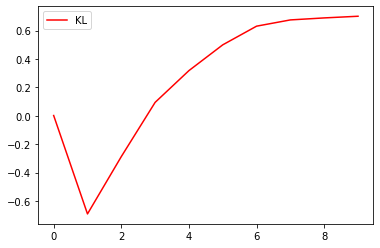

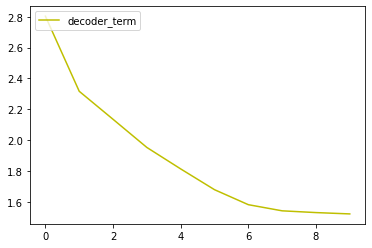

In [16]:
plt.plot(np.arange(epochs_num),np.log2(train_loss_2), '-b', label = 'ELBO')
plt.legend(loc='upper left')
plt.show()
plt.plot(np.arange(epochs_num),np.log2(KL_loss_2), '-r', label = 'KL')
plt.legend(loc='upper left')
plt.show()
plt.plot(np.arange(epochs_num),np.log2(decoder_loss_2), '-y', label = 'decoder_term')
plt.legend(loc='upper left') 
plt.show()

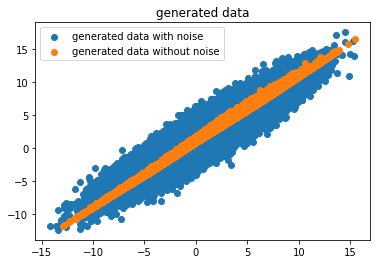

generated data mean tensor([1.0122, 2.0460], grad_fn=<MeanBackward1>) std tensor([3.5983, 3.5997], grad_fn=<StdBackward1>)


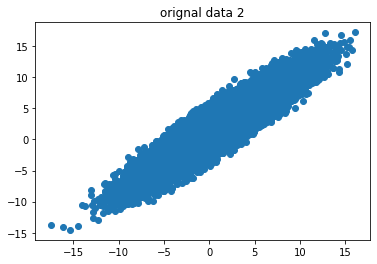

In [15]:
samples_num = 100000
z = torch.randn((samples_num,2))
z_=  torch.randn((samples_num,2))
m,cov = model_2.decoder(z)
samples_noise = m +  torch.exp(cov*0.5)*z_
samples = m
plt.title("generated data")
plt.scatter(samples_noise[:,0].detach(),samples_noise[:,1].detach(),label="generated data with noise")
plt.scatter(samples[:,0].detach(),samples[:,1].detach(),label="generated data without noise")
plt.legend()
plt.show()
print("generated data mean {} std {}".format(torch.mean(samples_noise,dim=0),torch.std(samples_noise,dim=0)))
plt.title("orignal data 2")
plt.scatter(data_2[:,0],data_2[:,1])
plt.show()

#### scalar variance model

In [0]:
model_scalar_2 = VAE(is_diagonal=False)
optimizer = torch.optim.Adam(model_scalar_2.parameters(), lr=1e-3)
epochs_num= 10
batch_size = 1000
indices = np.arange(len(data_2))

In [10]:
## Dataset 2
train_loss,KL_loss,decoder_loss = [],[],[]
for epoch in range(epochs_num):
  np.random.shuffle(indices)
  loss_epoch,KL_epoch,Dec_epoch=0,0,0
  for i,index in enumerate(range(0,len(indices),batch_size)): 
    optimizer.zero_grad()
    z = torch.randn((batch_size,2))
    x = torch.from_numpy(data_2[indices[index:index+batch_size]]).float()
    output = model_scalar_2(x,z)
    KL,Dec = criterion(*output,x)
    loss = KL+Dec
    loss.backward()
    optimizer.step()
    loss_epoch +=loss.item()
    KL_epoch +=KL.item()
    Dec_epoch +=Dec.item()
  train_loss.append(loss_epoch/i)
  KL_loss.append(KL_epoch/i)
  decoder_loss.append(Dec_epoch/i)
  print("epoch #{} loss {}".format(epoch,np.log(loss_epoch/i)))
  # model_save_name = 'vae_scalar_2.tar' 
  # path = F"/content/gdrive/My Drive/{model_save_name}"
  # state_dict = {"model": model_scalar_2.state_dict(), "optimizer": optimizer.state_dict()}
  # torch.save(state_dict, path)

epoch #0 loss 2.009019925000411
epoch #1 loss 1.7498105651659697
epoch #2 loss 1.7074091827415832
epoch #3 loss 1.6911791215355192
epoch #4 loss 1.669041989462285
epoch #5 loss 1.636211143331376
epoch #6 loss 1.6043000226188273
epoch #7 loss 1.574771592303058
epoch #8 loss 1.5468495336005352
epoch #9 loss 1.5169612071715555


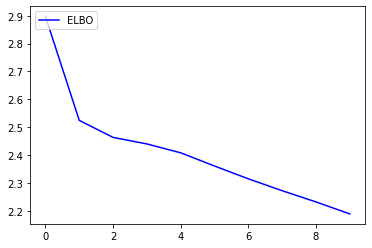

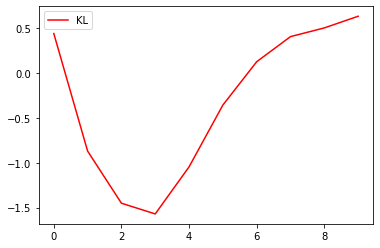

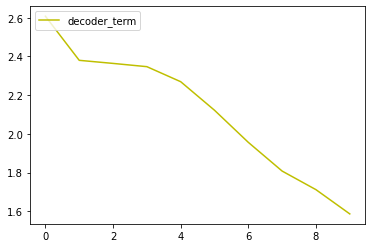

In [11]:
plt.plot(np.arange(epochs_num),np.log2(train_loss), '-b', label = 'ELBO')
plt.legend(loc='upper left')
plt.show()
plt.plot(np.arange(epochs_num),np.log2(KL_loss), '-r', label = 'KL')
plt.legend(loc='upper left')
plt.show()
plt.plot(np.arange(epochs_num),np.log2(decoder_loss), '-y', label = 'decoder_term')
plt.legend(loc='upper left') 
plt.show()

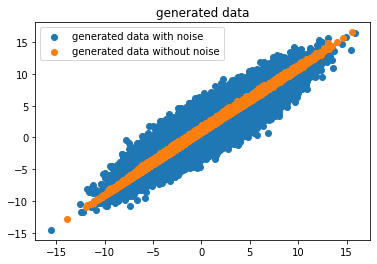

generated data mean tensor([1.0471, 2.0647], grad_fn=<MeanBackward1>) std tensor([3.5632, 3.5731], grad_fn=<StdBackward1>)


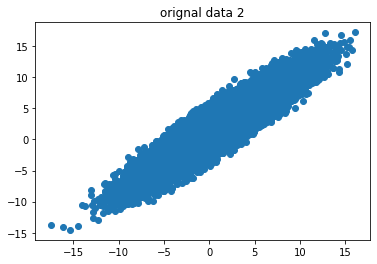

In [12]:
samples_num = 100000
z = torch.randn((samples_num,2))
z_=  torch.randn((samples_num,2))
# m,logcov = model_scalar_2.encoder(torch.from_numpy(data_2).float())
m,logcov = model_scalar_2.decoder(z)
samples_noise = m +  torch.exp(logcov*0.5)*z_
samples = m
plt.title("generated data")
plt.scatter(samples_noise[:,0].detach(),samples_noise[:,1].detach(),label="generated data with noise")
plt.scatter(samples[:,0].detach(),samples[:,1].detach(),label="generated data without noise")
plt.legend()
plt.show()
print("generated data mean {} std {}".format(torch.mean(samples_noise,dim=0),torch.std(samples_noise,dim=0)))
plt.title("orignal data 2")
plt.scatter(data_2[:,0],data_2[:,1])
plt.show()